In [1]:
import os
import numpy as np
import pandas as pd
import cv2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.1


### Importing the Kaggle dataset

In [3]:
# ! pip install -q kaggle

# from google.colab import files
# files.upload()

# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

In [4]:
# ! mkdir train
# ! mkdir test
# ! mkdir icml_face_data

# ! unzip train.csv.zip -d train
# ! unzip test.csv.zip -d test
# ! unzip icml_face_data.csv.zip -d icml_face_data

### Extracting the tar file

In [5]:
# ! mkdir fer2013.tar

# !tar -xvf  'fer2013.tar.gz' -C 'fer2013.tar'

### Converting Pixel to Image

In [6]:
# ! mkdir images

# fer_data=pd.read_csv('train/train.csv',delimiter=',')

# for index,row in fer_data.iterrows():
#   pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
#   img=pixels.reshape((48,48))
#   pathname=os.path.join('images',str(index)+'.jpg')
#   cv2.imwrite(pathname,img)
#   print('image saved ias {}'.format(pathname))

### Loading the data

In [7]:
fer_data = pd.read_csv("fer2013/fer2013.csv")
fer_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
fer_data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

### Splitting the data

In [9]:
data_train = fer_data[fer_data['Usage'] == 'Training'].copy()
data_validation = fer_data[fer_data['Usage'] == 'PrivateTest'].copy()
data_test = fer_data[fer_data['Usage'] == 'PublicTest'].copy()

In [10]:
print(f"Training data Shape: {data_train.shape}\nValidation data shape: {data_validation.shape}\nTest data shape: {data_test.shape}")

Training data Shape: (28709, 3)
Validation data shape: (3589, 3)
Test data shape: (3589, 3)


### Intializer

In [11]:
num_classes = 7
epochs = 5
batch_size = 64
num_features = 32
width, height = 48, 48

### Data Preprocessing

#### Perform CRNO (Convert, Reshape, Normalize, One-Hot-Encoding)

In [12]:
from keras.utils import to_categorical

In [13]:
def CRNO(df, dataName):
  df['pixels'] = df.loc[:,'pixels'].apply(lambda pixel_sequences: [int(pixel) for pixel in pixel_sequences.split()])
  data_x = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,48,48,1)/255.0
  data_y = to_categorical(df['emotion'],num_classes=num_classes)
  print(f"{dataName}_x Shape: {data_x.shape}\n{dataName}_y Shape: {data_y.shape}")
  return data_x, data_y

In [14]:
train_x, train_y = CRNO(data_train, "Train")
validation_x, validation_y = CRNO(data_validation, "Validation")
test_x, test_y = CRNO(data_test, "Test")

Train_x Shape: (28709, 48, 48, 1)
Train_y Shape: (28709, 7)
Validation_x Shape: (3589, 48, 48, 1)
Validation_y Shape: (3589, 7)
Test_x Shape: (3589, 48, 48, 1)
Test_y Shape: (3589, 7)


In [15]:
#Build the model
model = Sequential()
#Module1 conv<<conv<<batchnorm<<relu<<maxpooling<<dropout
model.add(Conv2D(2*num_features,kernel_size=(3,3), padding='same',data_format='channels_last',input_shape=(width, height, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
#Module2 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*num_features,kernel_size=(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
#Module3 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*2*num_features,kernel_size=(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

#cov 4
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Module4 fc<<batchnorm<<fc<<batchnorm<<dropout<<softmax
model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [16]:
from keras.callbacks import EarlyStopping

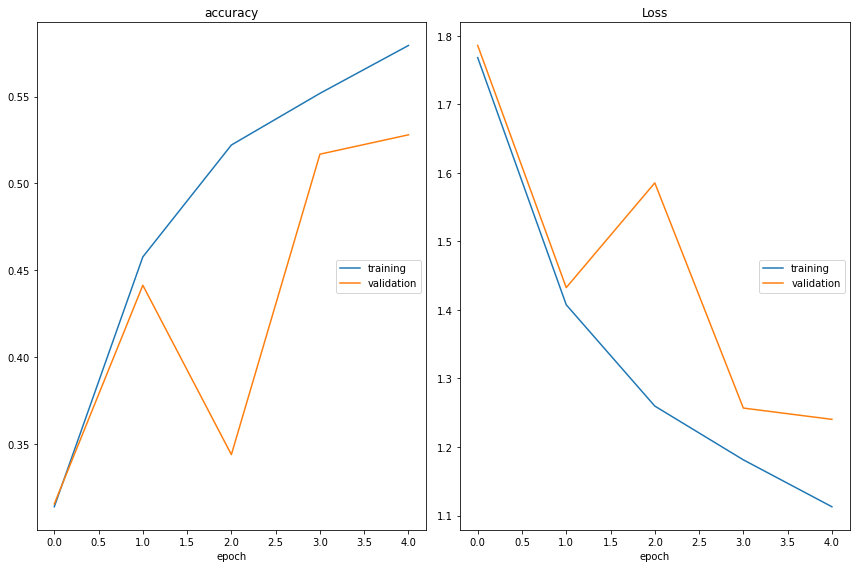

accuracy
	training         	 (min:    0.314, max:    0.579, cur:    0.579)
	validation       	 (min:    0.315, max:    0.528, cur:    0.528)
Loss
	training         	 (min:    1.113, max:    1.768, cur:    1.113)
	validation       	 (min:    1.240, max:    1.786, cur:    1.240)

Epoch 00005: saving model to model_weight.h5
449/449 [==============================] - 1557s 3s/step - loss: 1.1129 - accuracy: 0.5795 - val_loss: 1.2404 - val_accuracy: 0.5280


In [17]:
# steps_per_epoch = train_generator.n//train_generator.batch_size
# validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weight.h5", monitor='val_accuracy',
                            save_weights_only = True, mode='max', verbose=1
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr = 0.00001, mode='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
                    x = train_x,
                    y = train_y,
                    epochs=epochs,
                    batch_size = batch_size,
                    validation_data=(validation_x, validation_y),
                    callbacks=callbacks
                    )

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
test_true = np.argmax(test_y, axis=1)
test_pred = np.argmax(model.predict(test_x),axis=1)
print("CNN Model Accuracy : {}".format(accuracy_score(test_true,test_pred)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CNN Model Accuracy : 0.5266090833101142


### Model to json

In [20]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)